## Import Libraries

In [32]:
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
import matplotlib.pyplot as plt
import os

## Define Constants

In [27]:
FAST_RUN = True
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

## Prepare data

### Split

In [9]:
from sklearn.model_selection import train_test_split
df = pd.read_csv("pics.csv")
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=97)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [11]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

### Traning and Validation Generator
Make modifications to pictures to increase the pool

In [18]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "data/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [20]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "data/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


#### Ejemplo

In [21]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "data/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


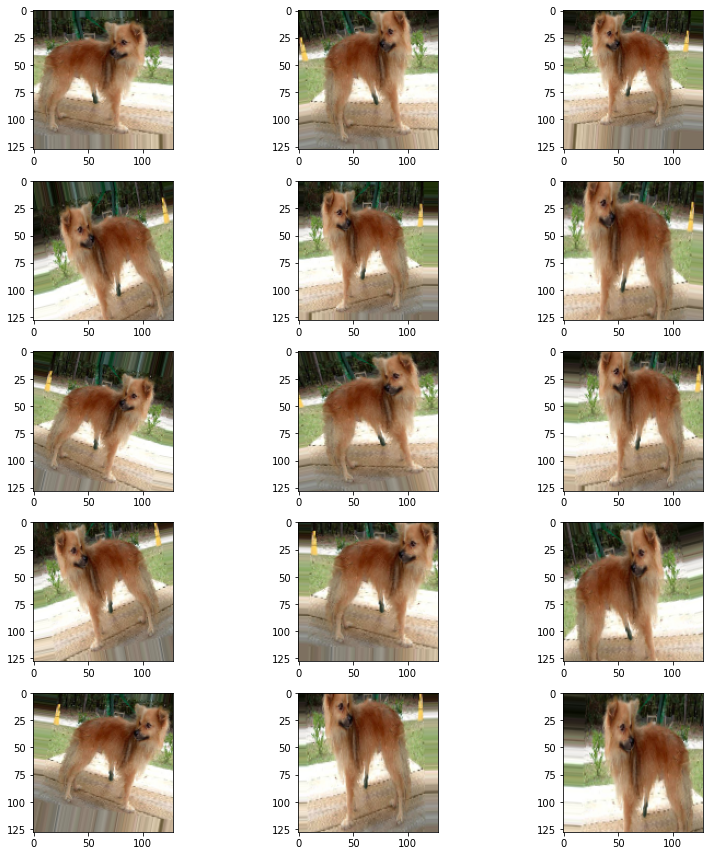

In [24]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

## Create model

In [3]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

# Ejecutado capa a capa
model = Sequential()

# 3 Grupos:

# # Primero:
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# # Segundo:
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# # Tercero:
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# # Cuarto:
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes


model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

### Callbacks

In [4]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

**Early Stop**

To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

In [5]:
earlystop = EarlyStopping(patience=10)

**Learning Rate Reduction**

We will reduce the learning rate when then accuracy not increase for 2 steps

In [6]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [7]:
callbacks = [earlystop, learning_rate_reduction]

## Fit model

In [28]:
epochs = 3 if FAST_RUN else 50
history = model.fit_generator(train_generator,
                              epochs=epochs,
                              validation_data=validation_generator,
                              validation_steps=total_validate // batch_size,
                              steps_per_epoch=total_train // batch_size,
                              callbacks=callbacks)  # Los callbacks definidos antes

Epoch 1/3
1333/1333 [==============================] - 117s 88ms/step - loss: 0.5118 - accuracy: 0.7532 - val_loss: 0.8807 - val_accuracy: 0.6923
Epoch 2/3
1333/1333 [==============================] - 127s 95ms/step - loss: 0.4744 - accuracy: 0.7776 - val_loss: 0.4140 - val_accuracy: 0.8236
Epoch 3/3
1333/1333 [==============================] - 120s 90ms/step - loss: 0.4480 - accuracy: 0.7987 - val_loss: 0.3868 - val_accuracy: 0.8320


In [29]:
model.save_weights("model.h5")

KeyError: 'acc'

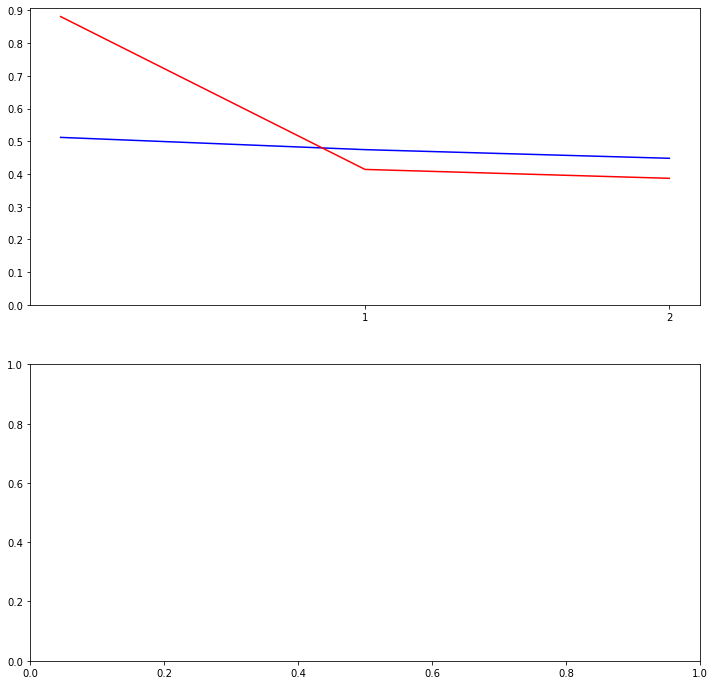

In [30]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [33]:
test_filenames = os.listdir("data/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [34]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "data/test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


In [47]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

In [48]:
test_df['category'] = predict
test_df

,filename,category
0,1.jpg,0.591914
1,10.jpg,0.800230
2,100.jpg,0.426576
3,1000.jpg,0.074115
4,10000.jpg,0.220466
...,...,...
12495,9995.jpg,0.638287
12496,9996.jpg,0.133440
12497,9997.jpg,0.199395
12498,9998.jpg,0.951373


In [37]:
# test_df['category'] = np.argmax(predict, axis=-1)

In [38]:
# label_map = dict((v,k) for k,v in train_generator.class_indices.items())
# test_df['category'] = test_df['category'].replace(label_map)

In [39]:
# test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

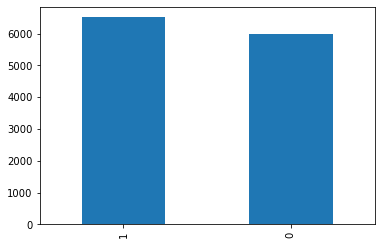

In [40]:
# test_df['category'].value_counts().plot.bar()

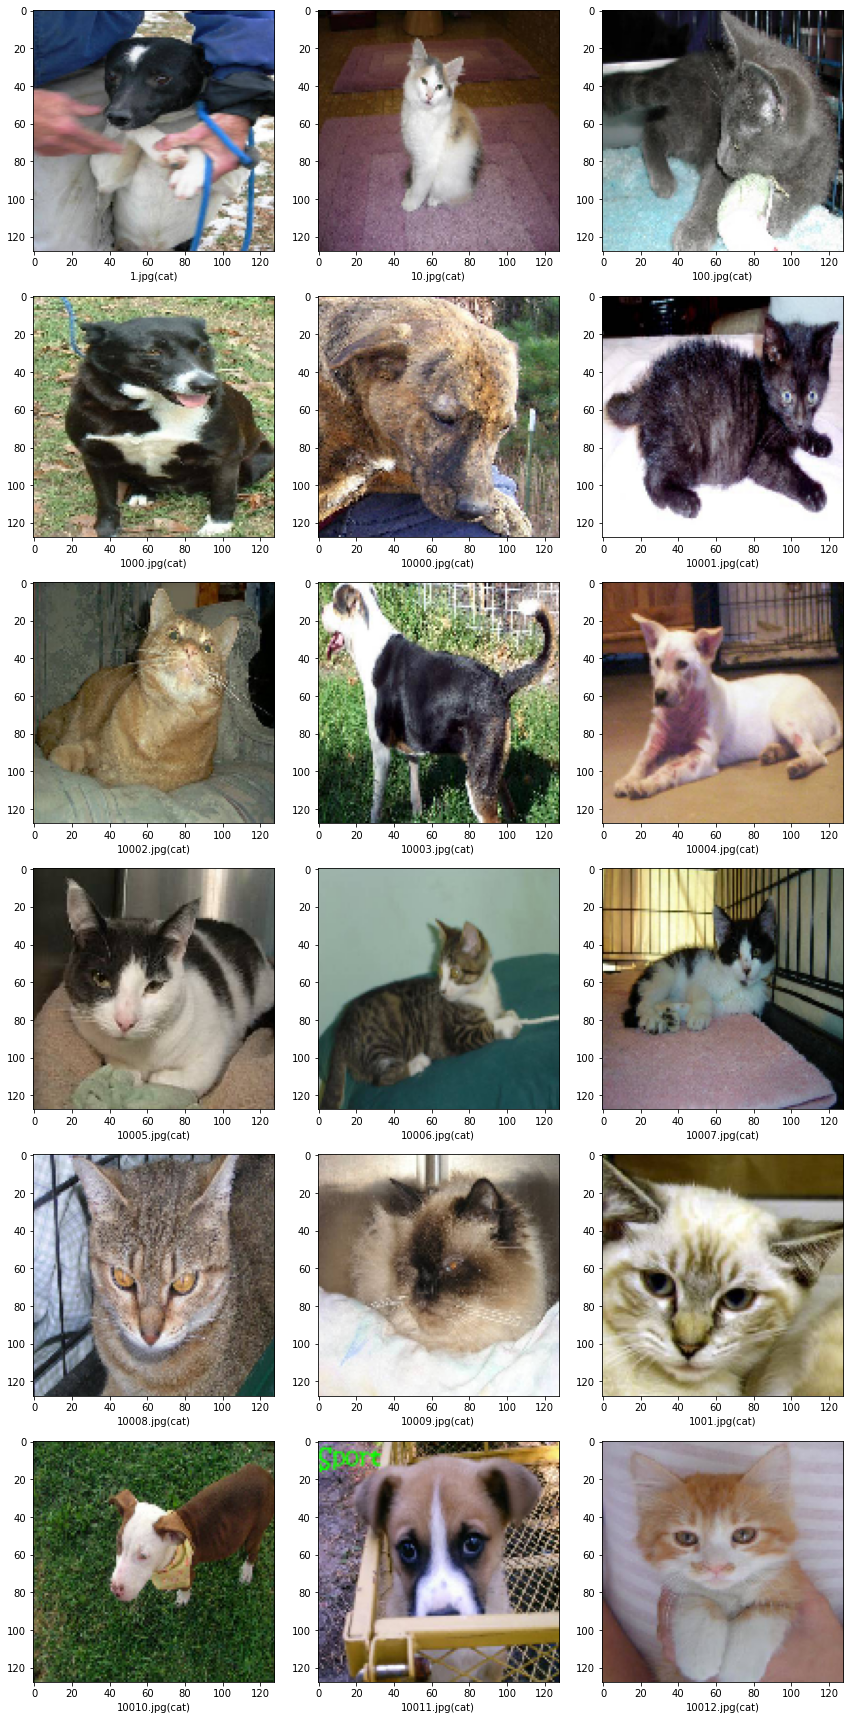

In [49]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("data/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format("dog" if 1==category else "cat") + ')' )
plt.tight_layout()
plt.show()

In [50]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)